In [1]:
from pathlib import Path
import duckdb
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = Path.home() / 'OneDrive - Seagroup/ai/kaggle_dataset/child-mind-institute-detect-sleep-states'
plt.style.use('ggplot')

# 1. Test Data

In [3]:
file = next(path.glob('test*.parquet'))
query = f"""select * from read_parquet('{file}') limit 5"""
duckdb.sql(query)

┌──────────────┬────────┬──────────────────────────┬────────┬────────┐
│  series_id   │  step  │        timestamp         │ anglez │  enmo  │
│   varchar    │ uint32 │         varchar          │ float  │ float  │
├──────────────┼────────┼──────────────────────────┼────────┼────────┤
│ 038441c925bb │      0 │ 2018-08-14T15:30:00-0400 │ 2.6367 │ 0.0217 │
│ 038441c925bb │      1 │ 2018-08-14T15:30:05-0400 │ 2.6368 │ 0.0215 │
│ 038441c925bb │      2 │ 2018-08-14T15:30:10-0400 │  2.637 │ 0.0216 │
│ 038441c925bb │      3 │ 2018-08-14T15:30:15-0400 │ 2.6368 │ 0.0213 │
│ 038441c925bb │      4 │ 2018-08-14T15:30:20-0400 │ 2.6368 │ 0.0215 │
└──────────────┴────────┴──────────────────────────┴────────┴────────┘

# 2. Train Data

## 2.1 Clean nulls

In [4]:
def check_null(df):
    print(f"Before drop nulls: Shape{df.shape}, # series {df['series_id'].n_unique()}")
    print(df.null_count())
    df_drop = df.drop_nulls()
    print(f"After drop nulls: Shape{df_drop.shape}, # series {df_drop['series_id'].n_unique()}")
    return df_drop

In [5]:
# csv
file_csv = next(path.glob('train*.csv'))
query = f"""select series_id
, night
, event
, cast(step as int) step
, cast(timestamp as varchar) as timestamp
from read_csv_auto('{file_csv}')"""
df_csv = (
    duckdb.sql(query).pl()
    .with_columns(pl.col('timestamp').str.to_datetime(format='%Y-%m-%d %H:%M:%S'))
    .shrink_to_fit()
)
print(df_csv.shape, df_csv.schema)

df_csv = check_null(df_csv)
df_csv.head()

(14510, 5) {'series_id': Utf8, 'night': Int64, 'event': Utf8, 'step': Int32, 'timestamp': Datetime(time_unit='us', time_zone=None)}
Before drop nulls: Shape(14510, 5), # series 277
shape: (1, 5)
┌───────────┬───────┬───────┬──────┬───────────┐
│ series_id ┆ night ┆ event ┆ step ┆ timestamp │
│ ---       ┆ ---   ┆ ---   ┆ ---  ┆ ---       │
│ u32       ┆ u32   ┆ u32   ┆ u32  ┆ u32       │
╞═══════════╪═══════╪═══════╪══════╪═══════════╡
│ 0         ┆ 0     ┆ 0     ┆ 4923 ┆ 4923      │
└───────────┴───────┴───────┴──────┴───────────┘
After drop nulls: Shape(9587, 5), # series 269


series_id,night,event,step,timestamp
str,i64,str,i32,datetime[μs]
"""038441c925bb""",1,"""onset""",4992,2018-08-15 02:26:00
"""038441c925bb""",1,"""wakeup""",10932,2018-08-15 10:41:00
"""038441c925bb""",2,"""onset""",20244,2018-08-15 23:37:00
"""038441c925bb""",2,"""wakeup""",27492,2018-08-16 09:41:00
"""038441c925bb""",3,"""onset""",39996,2018-08-17 03:03:00


In [6]:
check_label = df_csv.to_pandas().groupby('series_id')['event'].nunique()
check_label[check_label != 2]

Series([], Name: event, dtype: int64)

In [7]:
# parquet
file_parquet = next(path.glob('train*.parquet'))
query = f"""select series_id 
, cast(step as int) step
, anglez
, enmo
, cast(timestamp as varchar) as timestamp
from read_parquet('{file_parquet}')"""
df_parquet = (
    duckdb.sql(query).pl()
    .with_columns(pl.col('timestamp').str.to_datetime(format='%Y-%m-%dT%H:%M:%S%z').dt.replace_time_zone(None))
    .shrink_to_fit()
)
print(df_parquet.shape, df_parquet.schema)

df_parquet = check_null(df_parquet)
df_parquet.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(127946340, 5) {'series_id': Utf8, 'step': Int32, 'anglez': Float32, 'enmo': Float32, 'timestamp': Datetime(time_unit='us', time_zone=None)}
Before drop nulls: Shape(127946340, 5), # series 277
shape: (1, 5)
┌───────────┬──────┬────────┬──────┬───────────┐
│ series_id ┆ step ┆ anglez ┆ enmo ┆ timestamp │
│ ---       ┆ ---  ┆ ---    ┆ ---  ┆ ---       │
│ u32       ┆ u32  ┆ u32    ┆ u32  ┆ u32       │
╞═══════════╪══════╪════════╪══════╪═══════════╡
│ 0         ┆ 0    ┆ 0      ┆ 0    ┆ 0         │
└───────────┴──────┴────────┴──────┴───────────┘
After drop nulls: Shape(127946340, 5), # series 277


series_id,step,anglez,enmo,timestamp
str,i32,f32,f32,datetime[μs]
"""038441c925bb""",0,2.6367,0.0217,2018-08-14 19:30:00
"""038441c925bb""",1,2.6368,0.0215,2018-08-14 19:30:05
"""038441c925bb""",2,2.637,0.0216,2018-08-14 19:30:10
"""038441c925bb""",3,2.6368,0.0213,2018-08-14 19:30:15
"""038441c925bb""",4,2.6368,0.0215,2018-08-14 19:30:20


### Merge

In [8]:
df_csv = df_csv.with_columns(pl.col('event').map_dict({'wakeup': 1, 'onset': 0}).alias('is_wakeup'))
df_csv.head(10)

series_id,night,event,step,timestamp,is_wakeup
str,i64,str,i32,datetime[μs],i64
"""038441c925bb""",1,"""onset""",4992,2018-08-15 02:26:00,0
"""038441c925bb""",1,"""wakeup""",10932,2018-08-15 10:41:00,1
"""038441c925bb""",2,"""onset""",20244,2018-08-15 23:37:00,0
"""038441c925bb""",2,"""wakeup""",27492,2018-08-16 09:41:00,1
"""038441c925bb""",3,"""onset""",39996,2018-08-17 03:03:00,0
"""038441c925bb""",3,"""wakeup""",44400,2018-08-17 09:10:00,1
"""038441c925bb""",4,"""onset""",57240,2018-08-18 03:00:00,0
"""038441c925bb""",4,"""wakeup""",62856,2018-08-18 10:48:00,1
"""038441c925bb""",6,"""onset""",91296,2018-08-20 02:18:00,0


In [9]:
print(df_parquet.schema)
print(df_csv.schema)

{'series_id': Utf8, 'step': Int32, 'anglez': Float32, 'enmo': Float32, 'timestamp': Datetime(time_unit='us', time_zone=None)}
{'series_id': Utf8, 'night': Int64, 'event': Utf8, 'step': Int32, 'timestamp': Datetime(time_unit='us', time_zone=None), 'is_wakeup': Int64}


### Unit Test

In [10]:
# merge
query = f"""
select p.*
, c.is_wakeup
, strftime(p.timestamp, '%Y-%m-%d') as grass_date
, strftime(p.timestamp, '%H:%M:00') as grass_hour
from df_parquet p
left join df_csv c on p.series_id = c.series_id and p.timestamp = c.timestamp
where p.series_id = '03d92c9f6f8a'
"""
df_merge = (
    duckdb.sql(query).pl()
    .sort(['series_id', 'timestamp'])
)
print(df_merge.shape)
df_merge.head(10)

(724140, 8)


series_id,step,anglez,enmo,timestamp,is_wakeup,grass_date,grass_hour
str,i32,f32,f32,datetime[μs],i64,str,str
"""03d92c9f6f8a""",0,38.892899,0.0803,2018-05-31 16:00:00,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",1,29.374399,0.0752,2018-05-31 16:00:05,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",2,37.225101,0.1791,2018-05-31 16:00:10,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",3,46.937,0.0922,2018-05-31 16:00:15,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",4,60.486698,0.0342,2018-05-31 16:00:20,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",5,51.1558,0.0746,2018-05-31 16:00:25,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",6,25.8466,0.0721,2018-05-31 16:00:30,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",7,30.051701,0.0517,2018-05-31 16:00:35,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",8,25.9347,0.1069,2018-05-31 16:00:40,null,"""2018-05-31""","""16:00:00"""


In [11]:
df_merge['is_wakeup'].value_counts()

is_wakeup,counts
i64,u32
0,8
1,8
null,724124


In [12]:
filter_ = (pl.col('grass_date') == '2018-06-01') & (pl.col('grass_hour').is_in(['00:14:00', '10:47:00']))
df_merge.filter(filter_).with_columns(pl.col('is_wakeup').forward_fill())

series_id,step,anglez,enmo,timestamp,is_wakeup,grass_date,grass_hour
str,i32,f32,f32,datetime[μs],i64,str,str
"""03d92c9f6f8a""",5928,51.522301,0.0816,2018-06-01 00:14:00,0,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5929,69.1726,0.0,2018-06-01 00:14:05,0,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5930,69.367401,0.0,2018-06-01 00:14:10,0,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5931,69.852798,0.0,2018-06-01 00:14:15,0,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5932,69.852798,0.0,2018-06-01 00:14:20,0,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5933,69.852798,0.0,2018-06-01 00:14:25,0,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5934,69.852798,0.0,2018-06-01 00:14:30,0,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5935,69.852798,0.0,2018-06-01 00:14:35,0,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5936,69.852798,0.0,2018-06-01 00:14:40,0,"""2018-06-01""","""00:14:00"""


In [13]:
df_merge.with_columns(pl.col('is_wakeup').forward_fill())['is_wakeup'].value_counts()

is_wakeup,counts
i64,u32
0,62652
1,655560
null,5928


In [14]:
# merge
query = f"""
select p.*
, c.is_wakeup
, strftime(p.timestamp, '%Y-%m-%d') as grass_date
, strftime(p.timestamp, '%H:%M:%S') as grass_hour
from df_parquet p
left join df_csv c on p.series_id = c.series_id and p.timestamp = c.timestamp
"""
df_merge_full = (
    duckdb.sql(query).pl()
    .sort(['series_id', 'timestamp'])
    .with_columns(pl.col('is_wakeup').forward_fill())
    .shrink_to_fit()
)
print(df_merge_full.shape)
df_merge_full.head(10)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(127946340, 8)


series_id,step,anglez,enmo,timestamp,is_wakeup,grass_date,grass_hour
str,i32,f32,f32,datetime[μs],i64,str,str
"""038441c925bb""",0,2.6367,0.0217,2018-08-14 19:30:00,null,"""2018-08-14""","""19:30:00"""
"""038441c925bb""",1,2.6368,0.0215,2018-08-14 19:30:05,null,"""2018-08-14""","""19:30:05"""
"""038441c925bb""",2,2.637,0.0216,2018-08-14 19:30:10,null,"""2018-08-14""","""19:30:10"""
"""038441c925bb""",3,2.6368,0.0213,2018-08-14 19:30:15,null,"""2018-08-14""","""19:30:15"""
"""038441c925bb""",4,2.6368,0.0215,2018-08-14 19:30:20,null,"""2018-08-14""","""19:30:20"""
"""038441c925bb""",5,2.6367,0.0217,2018-08-14 19:30:25,null,"""2018-08-14""","""19:30:25"""
"""038441c925bb""",6,2.6367,0.0217,2018-08-14 19:30:30,null,"""2018-08-14""","""19:30:30"""
"""038441c925bb""",7,2.6367,0.0218,2018-08-14 19:30:35,null,"""2018-08-14""","""19:30:35"""
"""038441c925bb""",8,2.798,0.0223,2018-08-14 19:30:40,null,"""2018-08-14""","""19:30:40"""


In [15]:
label_stats = df_merge_full['is_wakeup'].value_counts() 
label_stats.with_columns((pl.col('counts') / pl.col('counts').sum()).alias('pct'))

is_wakeup,counts,pct
i64,u32,f64
0,29853816,0.233331
1,98087532,0.76663
null,4992,0.000039


## 2.2 check features

In [16]:
def plot(x, y, series_id, data, onset_time, wakeup_time):
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    sns.lineplot(data=data, x=x, y=y, hue='is_wakeup', ax=ax)
    for onset in onset_time:
        ax.axvline(x=onset, color='r', linestyle='--', label='onset')
    for wakeup in wakeup_time:
        ax.axvline(x=wakeup, color='g', linestyle='--', label='wakeup')
    
    # label
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels, new_handles = [], []
    for handle, label in zip(handles, labels):
        if label not in new_labels:
            new_handles.append(handle)
            new_labels.append(label)
            
    ax.legend(new_handles, new_labels)
    ax.set_title(f'[{y}] - series id {series_id}')
    fig.tight_layout()
    

def eda_series(series_id, df_merge_full, df_csv):
    filter_ = pl.col('series_id') == series_id
    unit_merge = df_merge_full.filter(filter_)
    unit_label = df_csv.filter(filter_)
    
    onset_time = unit_label.filter(pl.col('event') == 'onset')['timestamp']
    wakeup_time = unit_label.filter(pl.col('event') == 'wakeup')['timestamp']

    plot('timestamp', 'anglez', series_id, unit_merge, onset_time, wakeup_time)
    plot('timestamp', 'enmo', series_id, unit_merge, onset_time, wakeup_time)

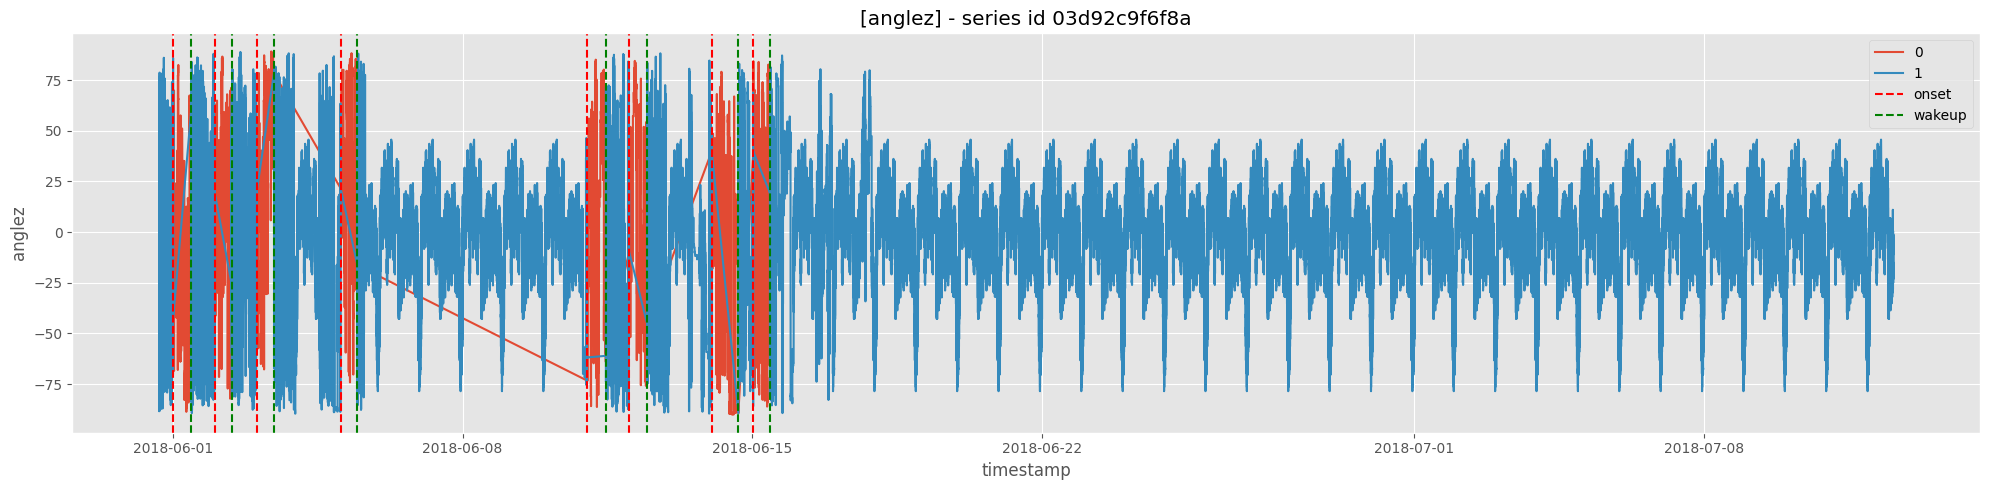

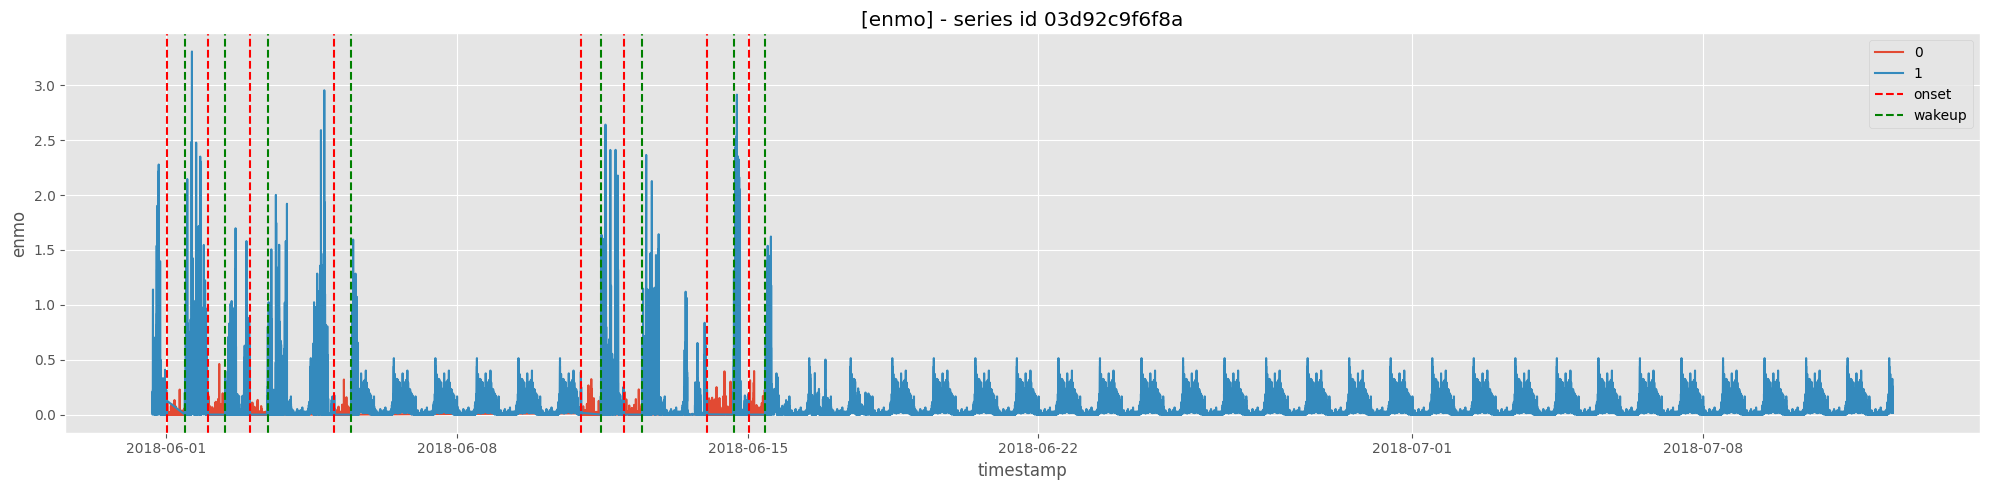

In [17]:
series_id = '03d92c9f6f8a'
eda_series(series_id, df_merge_full, df_csv)

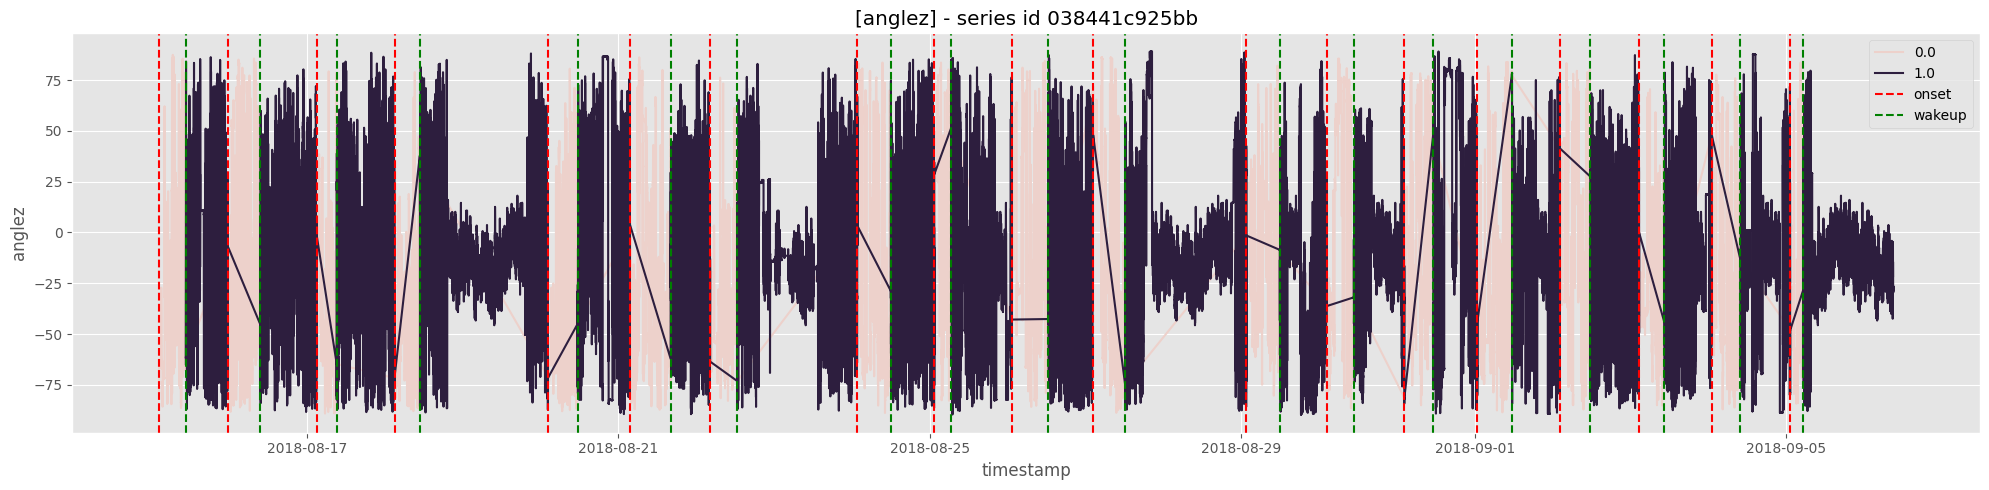

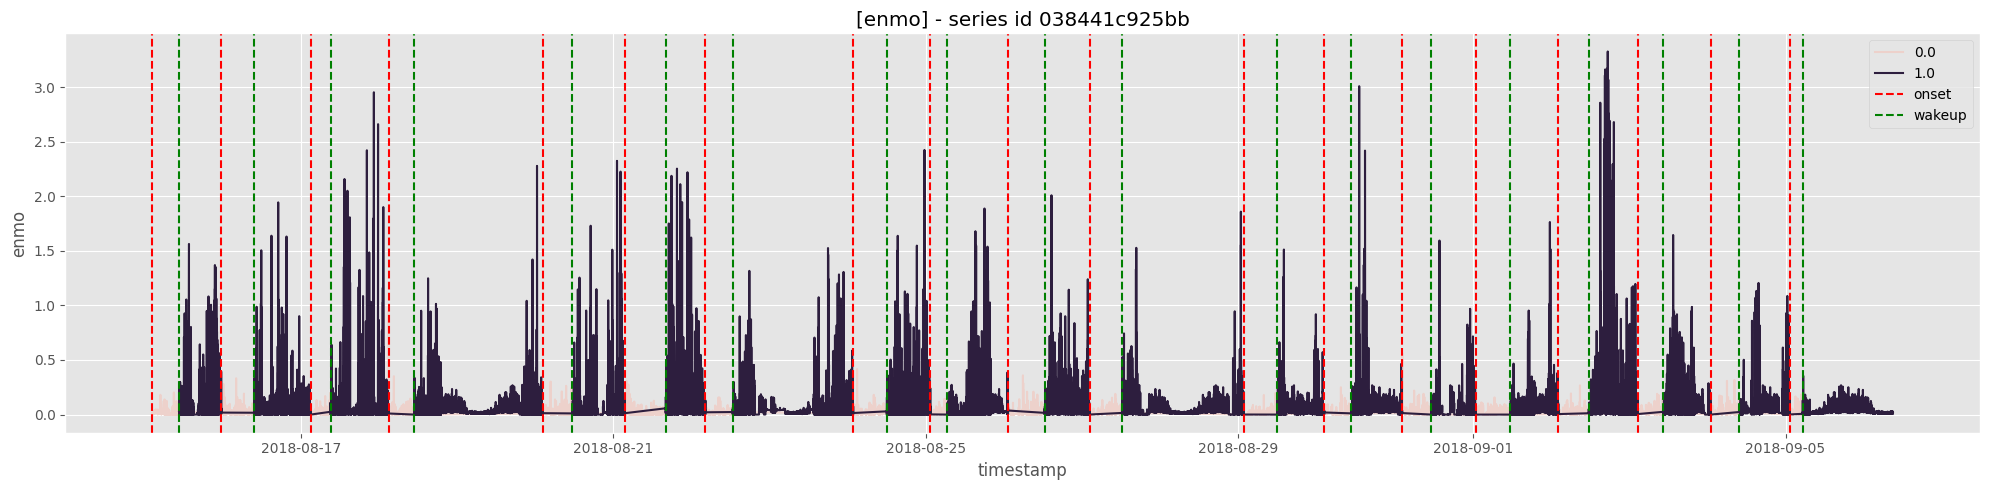

In [18]:
series_id = '038441c925bb'
eda_series(series_id, df_merge_full, df_csv)

In [19]:
df_merge_full.write_parquet(path / 'clean.parquet', use_pyarrow=True)